In [1]:
import numpy as np
from scipy import stats
import os

In [2]:

type_converter = {i: lambda x: int(x, 16) for i in range(16)}
PATH = "/home/navanerj/Documents/Model/DATA_JULY10"
MAX_ROWS = 10000
zeros_plaintexts = np.loadtxt(os.path.join(PATH, "zeros","plaintexts.txt"), dtype=np.uint8, max_rows=MAX_ROWS, converters=type_converter)
zeros_traces = np.loadtxt(os.path.join(PATH, "zeros","traces.txt"), max_rows=MAX_ROWS)

random_plaintexts = np.loadtxt(os.path.join(PATH, "random","plaintexts.txt"), dtype=np.uint8, max_rows=MAX_ROWS, converters=type_converter)
random_traces = np.loadtxt(os.path.join(PATH, "random","traces.txt"), max_rows=MAX_ROWS)
# traces_scaled = np.array([(np.array(trace)/127.0) for trace in traces])

In [3]:
start = 20000
length = 2500
zeros_traces_scaled = zeros_traces[:, start:start + length]
random_traces_scaled = random_traces[:, start:start + length]
half = MAX_ROWS // 2
random1 = random_traces_scaled[:half]
random2 = random_traces_scaled[half:]
fixed1 = zeros_traces_scaled[:half]
fixed2 = zeros_traces_scaled[half:]

t1 = np.zeros(length)
t2 = np.zeros(length)
for s in range(length):
    t1[s] = stats.ttest_ind(random1[:, s], fixed1[:, s], equal_var=False).statistic
    t2[s] = stats.ttest_ind(random2[:, s], fixed2[:, s], equal_var=False).statistic

# To check for leakage, find points where both |t1| > 4.5 and |t2| > 4.5 at the same point
leak_points = np.where((np.abs(t1) > 4.5) & (np.abs(t2) > 4.5))[0]

print("Number of leaking points (where both tests exceed threshold):", len(leak_points))
print("Max |t1|:", np.max(np.abs(t1)))
print("Max |t2|:", np.max(np.abs(t2)))

Number of leaking points (where both tests exceed threshold): 798
Max |t1|: 37.24785630571733
Max |t2|: 46.11390219127997


Dual t-test (both |t1| and |t2| > 4.5):
Number of leaking points: 798
Max |t1|: 37.24785630571733
Max |t2|: 46.11390219127997

Single t-test (|t_full| > 4.5):
Number of leaking points: 1299
Max |t_full|: 58.544038841458


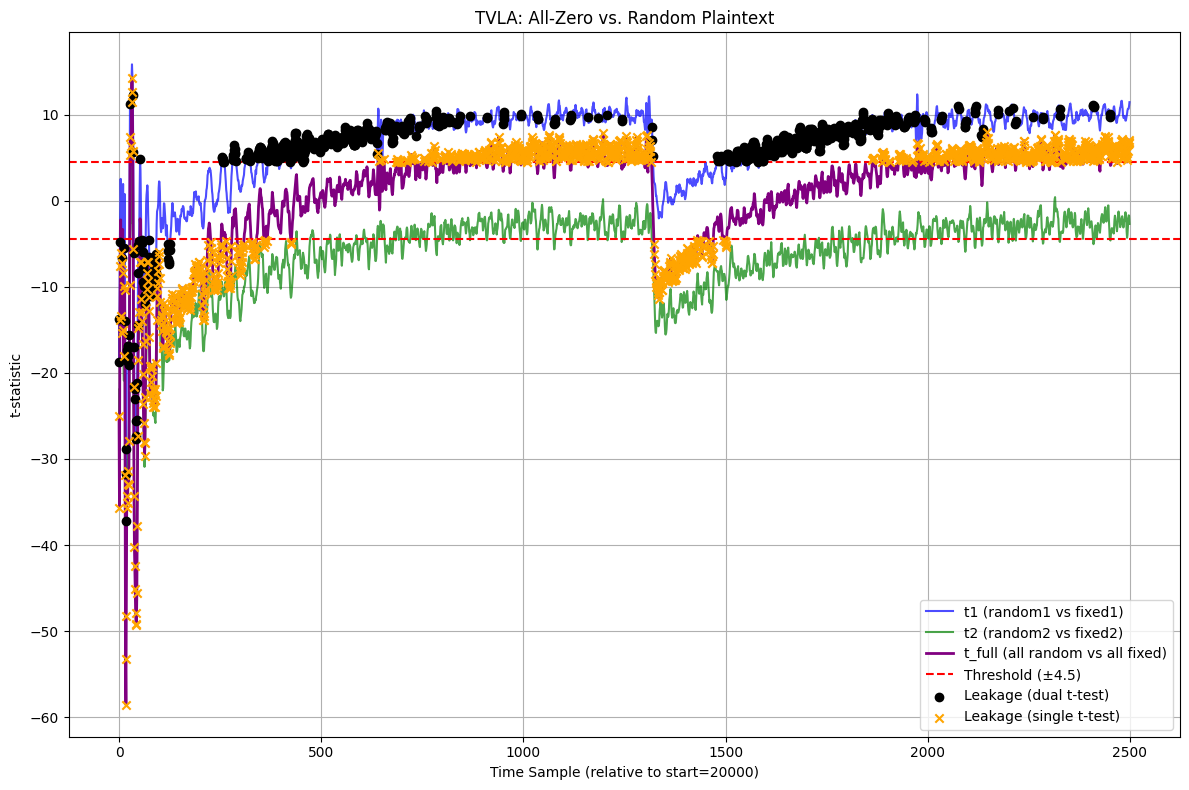

In [ ]:
import matplotlib.pyplot as plt
# Perform t-test on full dataset (standard TVLA)
t_full = np.zeros(length)
for s in range(length):
    t_full[s] = stats.ttest_ind(random_traces_scaled[:, s], zeros_traces_scaled[:, s], equal_var=False).statistic

leak_points_dual = np.where((np.abs(t1) > 4.5) & (np.abs(t2) > 4.5))[0] # Dual t-test: where both |t1| and |t2| > 4.5
leak_points_full = np.where(np.abs(t_full) > 4.5)[0] # Single t-test: where |t_full| > 4.5

# Print results
print("Dual t-test (both |t1| and |t2| > 4.5):")
print("Number of leaking points:", len(leak_points_dual))
print("Max |t1|:", np.max(np.abs(t1)))
print("Max |t2|:", np.max(np.abs(t2)))
print("\nSingle t-test (|t_full| > 4.5):")
print("Number of leaking points:", len(leak_points_full))
print("Max |t_full|:", np.max(np.abs(t_full)))

# Plot t-statistics
plt.figure(figsize=(12, 8))
plt.plot(t1, label="t1 (random1 vs fixed1)", color="blue", alpha=0.7)
plt.plot(t2, label="t2 (random2 vs fixed2)", color="green", alpha=0.7)
plt.plot(t_full, label="t_full (all random vs all fixed)", color="purple", linewidth=2)

plt.axhline(y=4.5, color="red", linestyle="--", label="Threshold (±4.5)")
plt.axhline(y=-4.5, color="red", linestyle="--")

# Highlight leakage points for dual t-test
if len(leak_points_dual) > 0:
    plt.scatter(leak_points_dual, t1[leak_points_dual], color="black", marker="o", label="Leakage (dual t-test)", zorder=5)

# Highlight leakage points for single t-test
if len(leak_points_full) > 0:
    plt.scatter(leak_points_full, t_full[leak_points_full], color="orange", marker="x", label="Leakage (single t-test)", zorder=5)

# Customize plot
plt.title("TVLA: All-Zero vs. Random Plaintext")
plt.xlabel("Time Sample (relative to start=20000)")
plt.ylabel("t-statistic")
plt.legend()
plt.grid(True)
plt.tight_layout()